In [1]:
import numpy as np # linear algebra
from numpy import newaxis
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM, GRU
from keras.models import Sequential
from keras import optimizers
from sklearn.preprocessing import MinMaxScaler
from itertools import combinations
import matplotlib.pyplot as plt
from scipy.stats import boxcox
plt.style.use('fivethirtyeight')

Enrol_window = 60

# Support functions
def load_data(datasetname, column, seq_len, normalise_window):
    # A support function to help prepare datasets for an RNN/LSTM/GRU
    data = datasetname.loc[:,column]

    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    if normalise_window:
        #result = sc.fit_transform(result)
        result = normalise_windows(result)

    result = np.array(result)

    #Last 10% is used for validation test, first 90% for training
    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    np.random.shuffle(train)
    x_train = train[:, :-1]
    y_train = train[:, -1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

    return [x_train, y_train, x_test, y_test]

def normalise_windows(window_data):
    # A support function to normalize a dataset
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

def predict_sequence_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of <prediction_len> steps before shifting prediction run forward by <prediction_len> steps
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

def plot_results(predicted_data, true_data): 
    fig = plt.figure(facecolor='white', figsize=(17, 5)) 
    ax = fig.add_subplot(111) 
    ax.plot(true_data, label='True Data') 
    plt.plot(predicted_data,label='Prediction') 
    plt.legend() 
    plt.show() 
    
def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white', figsize=(17, 5))
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show()
    
def add_div_diff_columns(df):
    data = df.copy()
    combs = list(combinations(["open","high","low","close", "volusdt", "tradecount"], 2))
    for comb in combs:
        cone = comb[0]
        ctwo = comb[1]
        
        data["div_"+cone+"_"+ctwo] = data[cone]/data[ctwo]
        data["div_flipped_"+cone+"_"+ctwo] = data[ctwo]/data[cone]
        data["diff_"+cone+"_"+ctwo] = np.abs(data[cone] - data[ctwo])
        
    return data

def create_windows(data, window_shape, step = 1, start_id = None, end_id = None):
    
    data = np.asarray(data)
    data = data.reshape(-1,1) if np.prod(data.shape) == max(data.shape) else data
        
    start_id = 0 if start_id is None else start_id
    end_id = data.shape[0] if end_id is None else end_id
    
    data = data[int(start_id):int(end_id),:]
    window_shape = (int(window_shape), data.shape[-1])
    step = (int(step),) * data.ndim
    slices = tuple(slice(None, None, st) for st in step)
    indexing_strides = data[slices].strides
    win_indices_shape = ((np.array(data.shape) - window_shape) // step) + 1
    
    new_shape = tuple(list(win_indices_shape) + list(window_shape))
    strides = tuple(list(indexing_strides) + list(data.strides))
    
    window_data = np.lib.stride_tricks.as_strided(data, shape=new_shape, strides=strides)
    
    return np.squeeze(window_data, 1)

def normalize(df):
    data = df.copy()
    for col in  list(df.columns):
        data[col] = data[col].replace(0,0.001)
        data[col] = boxcox(data[col])[0]
    return data



Using TensorFlow backend.


In [17]:
nrows = 1440 + 360
df = pd.read_csv("cryptodatadownload/Binance_SOLUSDT_minute.csv",nrows = nrows, skiprows = 1)[::-1].reset_index(drop = True)
df = df.drop(["unix"], axis = 1)
df = df.rename({"Volume USDT":"volusdt"}, axis = 1)
df = df.drop(["symbol"], axis = 1)
df = add_div_diff_columns(df)
newcols = list(df.columns[3:4]) + list(df.columns[:3]) + list(df.columns[4:])
df = df[newcols]
df = df.set_index('date')
temp = df.tail(360)
df = df.head(1440)

In [ ]:
feature_train, label_train, feature_test, label_test = load_data(df, 'close', Enrol_window, True)

In [3]:
model = Sequential()
model.add(GRU(50, return_sequences=True, input_shape=(feature_train.shape[1],feature_train.shape[2])))
model.add(Dropout(0.2))
model.add(GRU(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation = "linear"))

model.compile(loss='mse', optimizer='adam')

2021-12-01 01:46:03.862795: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-01 01:46:03.863261: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [8]:
model.fit(feature_train, label_train, batch_size=32, epochs=50, validation_data = (feature_test, label_test))

Train on 1241 samples, validate on 138 samples
Epoch 1/50
1241/1241 [==============================] - 18s 15ms/step - loss: 1.0432e-05 - val_loss: 9.6593e-06
Epoch 2/50
1241/1241 [==============================] - 21s 17ms/step - loss: 9.7863e-06 - val_loss: 4.9038e-06
Epoch 3/50
1241/1241 [==============================] - 19s 15ms/step - loss: 9.8827e-06 - val_loss: 5.2213e-06
Epoch 4/50
1241/1241 [==============================] - 18s 15ms/step - loss: 1.0146e-05 - val_loss: 7.3007e-06
Epoch 5/50
1241/1241 [==============================] - 22s 17ms/step - loss: 1.1053e-05 - val_loss: 1.6897e-05
Epoch 6/50
1241/1241 [==============================] - 30s 24ms/step - loss: 1.0922e-05 - val_loss: 4.7882e-06
Epoch 7/50
1241/1241 [==============================] - 31s 25ms/step - loss: 9.4374e-06 - val_loss: 4.9048e-06
Epoch 8/50
1241/1241 [==============================] - 28s 23ms/step - loss: 1.0077e-05 - val_loss: 4.8345e-06
Epoch 9/50
1241/1241 [==============================] - 3

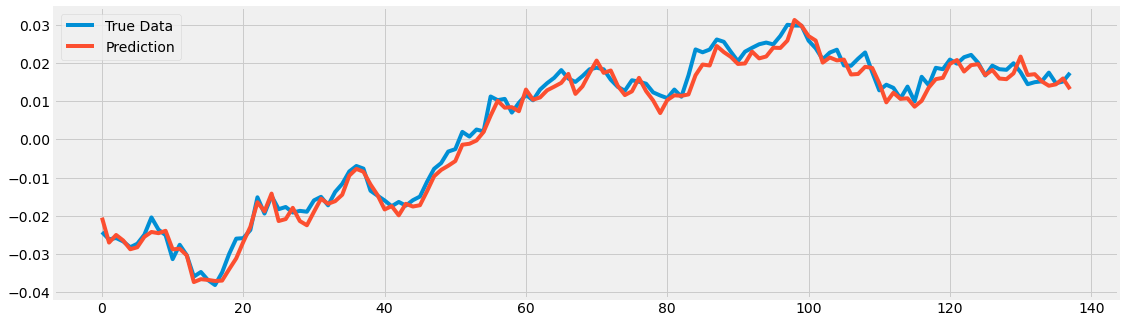

In [22]:
predicted_stock_price = model.predict(feature_test)
plot_results(predicted_stock_price,label_test)

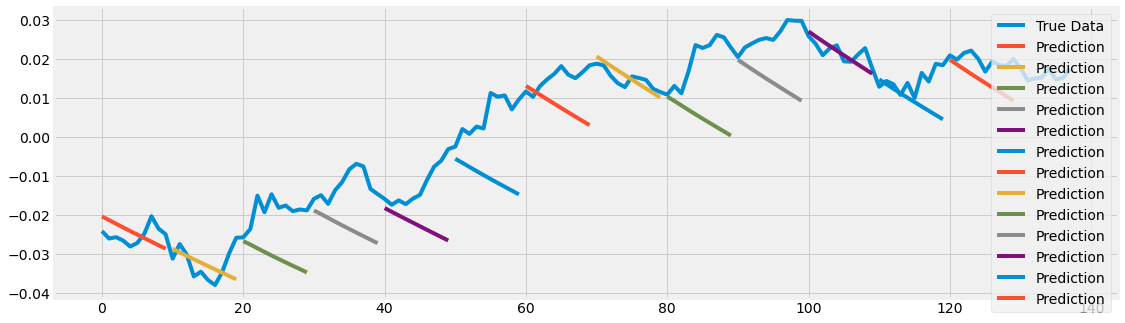

In [12]:
predictions = predict_sequences_multiple(model, feature_test, Enrol_window, 10)
plot_results_multiple(predictions, label_test, 10)  